<a href="https://colab.research.google.com/github/Boon-Yang/Machine-Learning-for-Defect-Detection-In-Additive-Manufacturing/blob/master/Skimage_Features_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import scipy.io as io
import os 
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import h5py

# Progress bar
from tqdm import tqdm

# Features Extraction
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon
from skimage.measure import regionprops, label
from statistics import mean

os.chdir('/content/drive/My Drive/FYP MAT Data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Functions

In [2]:
def show_hatching_path(cyl_build, hatching_range):  
  fig, axes = plt.subplots(nrows=3, ncols = 3, figsize=(15, 10))
  x_true_pos, y_true_pos = pos[cyl_build]

  # transpose the axes to match the sequence of builds
  axes = axes.T
  axes = axes.flatten()
  plt.tight_layout()
  for i, ax in enumerate(axes):
    ax.plot(x_true_pos[hatching_range[i+1]], y_true_pos[hatching_range[i+1]])
    ax.set_title('{}th block, ({})'.format(i+1, cyl_build))
  plt.show()

In [3]:
def show_images(imageIDs, data):
  if len(imageIDs) <= 20:
    fig, axes = plt.subplots(figsize=(20, 15), nrows = 4, ncols = int(np.ceil((len(imageIDs)/4))))
  else:
    fig, axes = plt.subplots(figsize=(30, 25), nrows = int(np.ceil((len(imageIDs)/4))), ncols = 4)
  plt.tight_layout()
  axes = axes.flatten()
  
  list(map(lambda x: x.set_axis_off(), axes))

  for idx, imageID in enumerate(imageIDs):
    ax=axes[idx]
    imageArray = data[imageID]
    ax.imshow(imageArray, cmap='inferno')
    ax.set_title(imageID)
  return axes

In [4]:
def get_val_between(df, col,  val_range=[40, 60]):
  '''
  val_range, a list: [upperBound, lowerBoud]
  df: dataFrame, default: featuresDataFrame
  col: the df's column of interest, default='std_dev'
  Return the indices of images which has std dev or any features in between the bounds.
  
  '''
  lower_bound = val_range[0]
  upper_bound = val_range[1]
  print(col)
  condition = df[col].apply(lambda x: lower_bound <= x < upper_bound)

  return df[condition == True].index.values

In [5]:
def disp_images_within_bound(lower_bound, higher_bound, col, number_of_images, df, data):
  image_index = get_val_between(df, col, val_range=[lower_bound, higher_bound])
  print('The lowerBound for {} is '.format(col) + str(lower_bound))
  print('The upperBound for {} is '.format(col) + str(higher_bound))  
  np.random.seed(seed=42)
  fig, axes = plt.subplots(nrows=int(number_of_images/5), ncols=5, figsize=(30, 25))
  displayed_imageId = []
  axes = axes.flatten()
  plt.tight_layout()

  for idx in range(number_of_images):
    # Generate random image Id
    i = np.random.randint(low=0, high=len(image_index))
    imageId = image_index[i]

    # Printing the images
    ax = axes[idx]
    ax.imshow(data[imageId], cmap='inferno')

    ax.set_axis_off()
    ax.set_title(imageId)
    displayed_imageId.append(imageId)
  return sorted(displayed_imageId)

# Load Data
In this Section, we load in the scan path data and manually parsed for the inner scan paths for further processing.

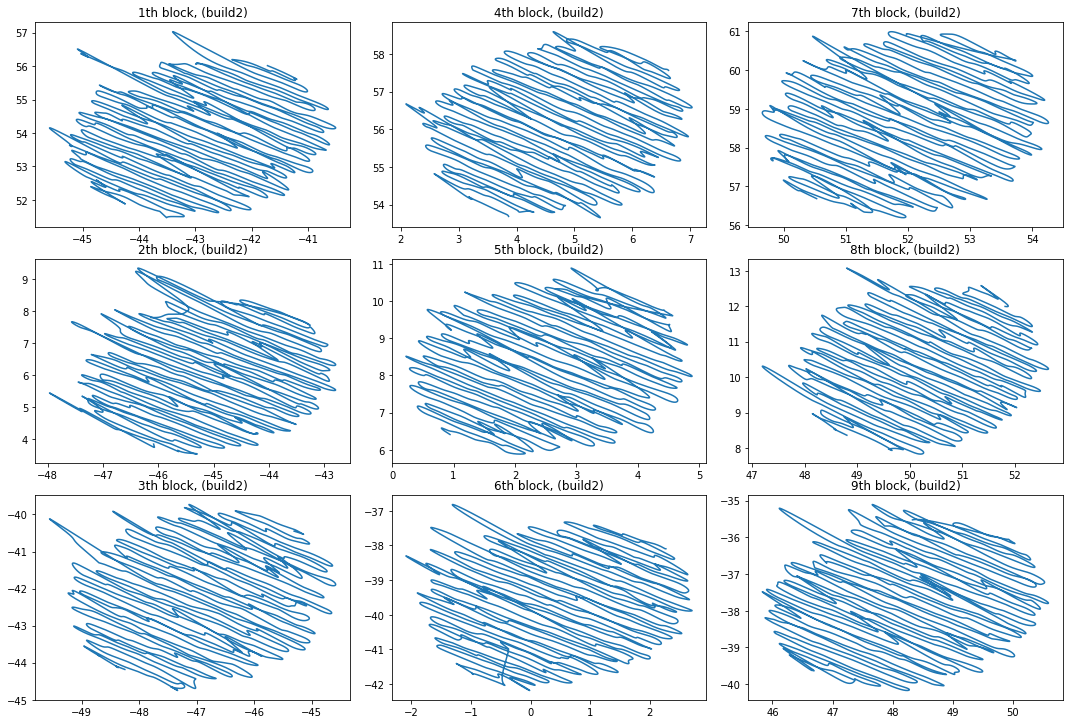

In [6]:
matfiles = [dir for dir in os.listdir() if '.mat' in dir and '200' not in dir]
builds = [x.split('_layer')[0] for x in matfiles]

pos = {}
x_true_pos = []
y_true_pos = []
count = 0

for matfile in matfiles:
  # print(matfile)
  f = h5py.File(matfile,'r')

  # all the variables in the mat file
  x_true_pos = f.get('x_true_pos')
  x_true_pos = np.array(x_true_pos)[0]

  y_true_pos = f.get('y_true_pos')
  y_true_pos = np.array(y_true_pos)[0]
  # print(builds[count])
  pos[builds[count]] = [x_true_pos, y_true_pos]
  count += 1

# build2's hatching range (coordinates of scan paths of each block)
hatching_range = {1: range(0, 26000),
                    2: range(39790,66250),
                    3: range(79700,105600),
                    4: range(120450,146400),
                    5: range(160500,186400),
                    6: range(200000,226000),
                    7: range(241000,267000),
                    8: range(280800,306700),
                    9: range(320480,346600)
                    }

show_hatching_path('build2', hatching_range)

# Features Extraction

In this section, we will extract spatter and blob features of all nine blocks.

In [25]:
# helper function to extract features
def extractFeatures(spatterProps, blobProps):
  quantitySpatter = len(spatterProps)
  quantityBlob = len(blobProps)
  if quantitySpatter > 0:
    averageSpatterArea = mean([prop.area for prop in spatterProps])
    averageSpatterEccenticity = mean([prop.eccentricity for prop in spatterProps])
  else:
    averageSpatterArea = 0
    averageSpatterEccenticity = 0

  if quantityBlob > 0:
    blobArea = blobProps[0].area
    blobEccentricity = blobProps[0].eccentricity
  else:
    blobArea = 0
    blobEccentricity = 0
  return quantitySpatter, averageSpatterArea, averageSpatterEccenticity, blobArea, blobEccentricity

In [8]:
 f = h5py.File('build2_layer_110.mat','r')

 data = f.get('temperatureimgs')
 data = np.array(data)

In [33]:
df = []
for blockNo, idRange in tqdm(hatching_range.items()):

  for idx in idRange:
    label_img = label(data[idx]>293)
    regions = regionprops(label_img)

    # Assume biggest blob is the melt pool itself, all other blobs are spatter particles
    if len(regions)>0:
        
      maxArea = max([prop.area for prop in regions if prop is not None])
      spatterProp = [prop for prop in regions if prop.area < maxArea]
      blobProp = [prop for prop in regions if prop.area == maxArea]

      # Extract Features
      features = list(extractFeatures(spatterProp, blobProp))
    else:
      features = [0, 0, 0, 0, 0]
    features.append(blockNo)
    features.append(idx)
    df.append(features)

100%|██████████| 9/9 [05:41<00:00, 37.92s/it]


In [40]:
df = pd.DataFrame(df, columns=['spatterNum', 'spatterArea', 
                          'spatterEccenticity', 'blobArea', 'blobEccentricity',
                          'blockNo', 'ImageId'] )
df = df[['blockNo', 'ImageId',
         'spatterNum', 'spatterArea',
         'spatterEccenticity', 'blobArea', 'blobEccentricity']]

In [41]:
df.tail()

,blockNo,ImageId,spatterNum,spatterArea,spatterEccenticity,blobArea,blobEccentricity
234225,9,346595,6,11,0.506534,62,0.479689
234226,9,346596,6,12,0.552474,61,0.603923
234227,9,346597,6,12,0.637814,61,0.535470
234228,9,346598,6,14,0.654799,63,0.477312
234229,9,346599,7,12,0.286866,53,0.459013


In [42]:
hatching_range

{1: range(0, 26000),
 2: range(39790, 66250),
 3: range(79700, 105600),
 4: range(120450, 146400),
 5: range(160500, 186400),
 6: range(200000, 226000),
 7: range(241000, 267000),
 8: range(280800, 306700),
 9: range(320480, 346600)}

In [43]:
os.getcwd()

'/content/drive/My Drive/FYP MAT Data'

In [44]:
df.to_csv('Build2_Features.csv', index=False)

In [46]:
# 0.3 ms per image
(5*6+41)/234229

0.0003031221582297666